In [1]:
!wget https://www.dropbox.com/s/l0vo83hmvv2aipn/crnn.pth

--2018-02-25 21:26:13--  https://www.dropbox.com/s/l0vo83hmvv2aipn/crnn.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ZeSYD70ytAsh0JaeMbpzEHHpVcvT4S0M8xXaJF11m9TFaF5q6sV3Y7GYBVQEnbV9/file [following]
--2018-02-25 21:26:13--  https://dl.dropboxusercontent.com/content_link/ZeSYD70ytAsh0JaeMbpzEHHpVcvT4S0M8xXaJF11m9TFaF5q6sV3Y7GYBVQEnbV9/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.7.6, 2620:100:601a:6::a27d:706
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.7.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33351680 (32M) [text/plain]
Saving to: 'crnn.pth'

crnn.pth            100%[===================>]  31.81M  10.2MB/s    in 3.3s    

2018-02-25 21:26:18 (9.72 MB/s) - 'c

In [2]:
import sys
sys.path.append('../../../server')

In [5]:
import crnn.utils as utils 
import crnn.dataset as dataset
import torch
from torch.autograd import Variable
from PIL import Image
import crnn.models.crnn as crnn
import glob
from IPython.core import display


model_path = 'crnn.pth'
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'
model = crnn.CRNN(32, 1, 37, 256, 1)
print('loading pretrained model from %s' % model_path)
model.load_state_dict(torch.load(model_path))
converter = utils.strLabelConverter(alphabet)
transformer = dataset.resizeNormalize((100, 32))

loading pretrained model from crnn.pth


e--x--e-r--e--g--a--t--e-- => exeregate           


f--o--o-d---ss-c-ra--p--s- => foodscraps          


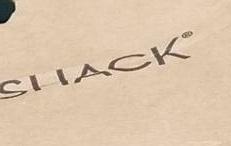

d-----r--r--c----v-----d-- => drrcvd              


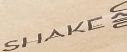

s----p----a---k---e----s-- => spakes              


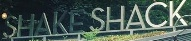

ss-h-a--k-e-ssh--aa-c--k-- => shakeshack          


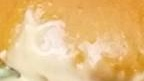

p-------a----------------- => pa                  


a-------------n---e--s-s-- => aness               


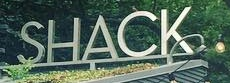

ss----h---a---c---k------- => shack               


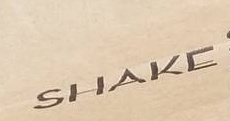

s-------t----a---k---e---- => stake               


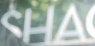

s-------h--------a-------- => sha                 


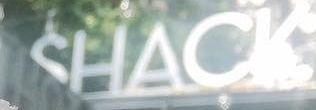

s-----h-----a---c---kk---- => shack               


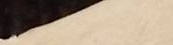

i--------------------n---- => in                  


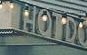

t------h----o-------d--s-- => thods               


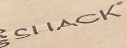

s--s---n----a---c---k----- => ssnack              


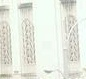

ii--------r-----a--------- => ira                 


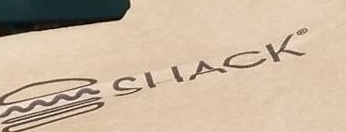

s---e----e-l---a-c--k--s-- => seelacks            


s---------------e-n----s-- => sens                


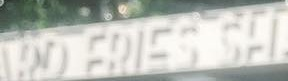

p----t-e--r--e--a--t-l---- => ptereatl            


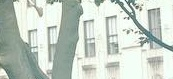

p------f-----g--e--------- => pfge                


In [8]:
for img_path in glob.glob('boxes/*.jpg'):
    image = Image.open(img_path).convert('L')
    image = transformer(image)
    image = image.view(1, *image.size())
    image = Variable(image)
    model.eval()
    preds = model(image)
    _, preds = preds.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
    sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
    display.display(display.Image(img_path))
    print('%-20s => %-20s' % (raw_pred, sim_pred))